# Segmentation of Road from Satellite imagery

In [4]:
from google.colab import drive
drive.mount('/content/gdrive/')
base_path = "gdrive/My\ Drive/39_GeoArchitect/"
%cd gdrive/My\ Drive/39_GeoArchitect/

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).
/content/gdrive/My Drive/39_GeoArchitect


## Importing Libraries

In [5]:
import warnings
warnings.filterwarnings('ignore')

import os
import cv2
from google.colab.patches import cv2_imshow
import numpy as np
import tensorflow as tf
import pandas as pd
from keras.models import Model, load_model
from skimage.morphology import label
import pickle
import tensorflow.keras.backend as K

from matplotlib import pyplot as plt
from tqdm import tqdm_notebook
import random
from skimage.io import imread, imshow, imread_collection, concatenate_images
from matplotlib import pyplot as plt
import h5py

seed = 56


Using TensorFlow backend.


## Loading Data

In [0]:
IMAGE_HEIGHT = IMAGE_WIDTH = 256
NUM_CHANNELS = 3
image_file = '../Data/new_train_images.h5py'
mask_file = '../Data/new_train_masks.h5py'

In [7]:
hfile = h5py.File(image_file, 'r')
n1 = hfile.get('all_images')
images = np.array(n1)
print(images.shape)
hfile.close()

(22226, 256, 256, 3)


In [8]:
hfile = h5py.File(mask_file, 'r')
n1 = hfile.get('all_masks')
masks = np.array(n1)
print(masks.shape)
print("Unique elements in the train mask:", np.unique(masks))
hfile.close()

(22226, 256, 256)
Unique elements in the train mask: [  0 255]


In [0]:
print(images.nbytes*9.537/100000)
# ONLY FOR TESTS
images = images[:20000]
masks = masks[:20000]
print(images.nbytes*9.537/100000)

## Displaying few Samples

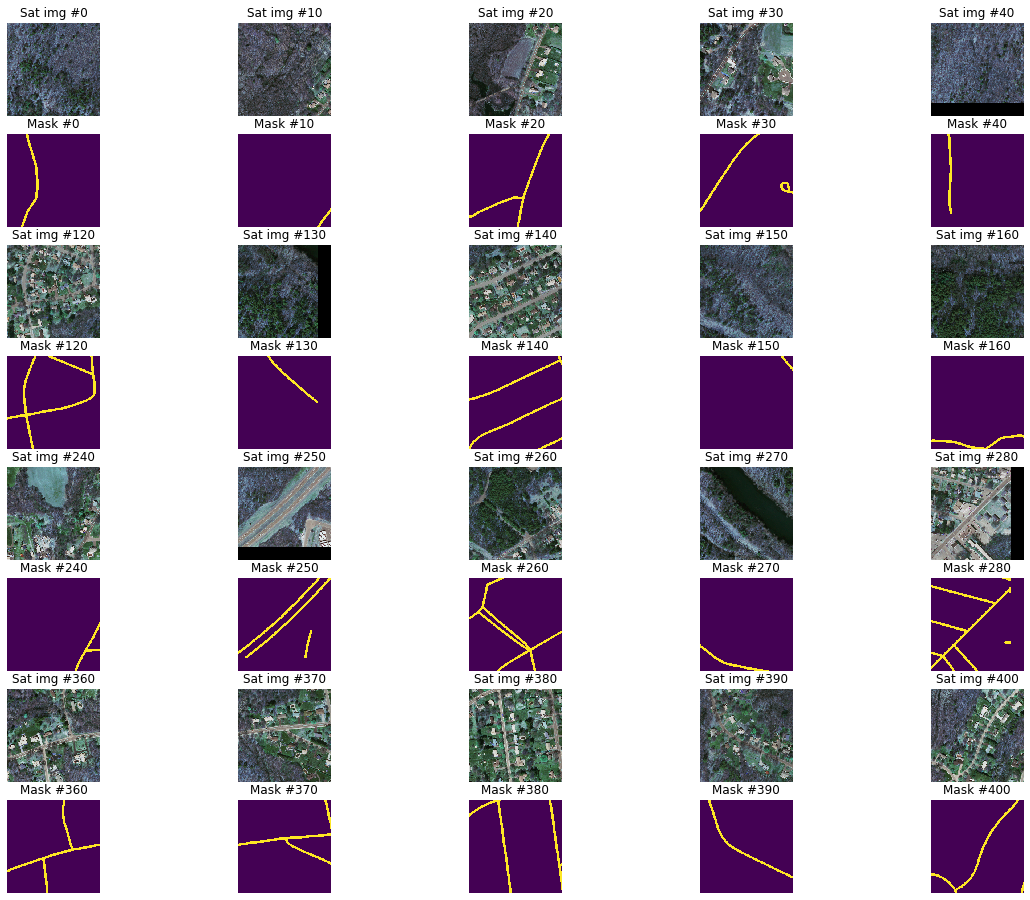

In [9]:
 plt.figure(figsize=(20,16))
x, y = 5,4
for i in range(y):  
    for j in range(x):
        plt.subplot(y*2, x, i*2*x+j+1)
        pos = i*120 + j*10
        plt.imshow(images[pos])
        plt.title('Sat img #{}'.format(pos))
        plt.axis('off')
        plt.subplot(y*2, x, (i*2+1)*x+j+1)
           
        #We display the associated mask we just generated above with the training image
        plt.imshow(masks[pos])
        plt.title('Mask #{}'.format(pos))
        plt.axis('off')
        
plt.show()

In [0]:
masks = np.expand_dims(masks, -1)

## Defining IOU Metric

In [0]:
def dice_loss(y_true, y_pred):
  numerator = 2 * tf.reduce_sum(y_true * y_pred, axis=(1,2,3))
  denominator = tf.reduce_sum(y_true + y_pred, axis=(1,2,3))

  return 1 - numerator / denominator

In [0]:
smooth = 1
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

In [13]:
print(masks.shape)
print(images.shape)

(22226, 256, 256, 1)
(22226, 256, 256, 3)


## Splitting data

In [14]:
from sklearn.model_selection import train_test_split
train_images, test_images, train_masks, test_masks = train_test_split(images, masks, test_size=0.2, random_state=seed)
del images, masks
print("TRAIN SET")
print(train_images.shape)
print(train_masks.shape)
print("TEST SET")
print(test_images.shape)
print(test_masks.shape)

TRAIN SET
(17780, 256, 256, 3)
(17780, 256, 256, 1)
TEST SET
(4446, 256, 256, 3)
(4446, 256, 256, 1)


## Defining Our Model

In [0]:
from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras import optimizers
from keras.layers import BatchNormalization
import keras

In [13]:
inputs = Input((IMAGE_HEIGHT, IMAGE_WIDTH, 3))
s = Lambda(lambda x: x / 255) (inputs)

c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (inputs)
c1 = BatchNormalization() (c1)
c1 = Dropout(0.1) (c1)
c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c1)
c1 = BatchNormalization() (c1)
p1 = MaxPooling2D((2, 2)) (c1)

c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p1)
c2 = BatchNormalization() (c2)
c2 = Dropout(0.1) (c2)
c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c2)
c2 = BatchNormalization() (c2)
p2 = MaxPooling2D((2, 2)) (c2)

c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p2)
c3 = BatchNormalization() (c3)
c3 = Dropout(0.2) (c3)
c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c3)
c3 = BatchNormalization() (c3)
p3 = MaxPooling2D((2, 2)) (c3)

c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p3)
c4 = BatchNormalization() (c4)
c4 = Dropout(0.2) (c4)
c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c4)
c4 = BatchNormalization() (c4)
p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p4)
c5 = BatchNormalization() (c5)
c5 = Dropout(0.3) (c5)
c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c5)
c5 = BatchNormalization() (c5)


u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (c5)
u6 = concatenate([u6, c4])
c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u6)
c6 = BatchNormalization() (c6)
c6 = Dropout(0.2) (c6)
c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c6)
c6 = BatchNormalization() (c6)

u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c6)
u7 = concatenate([u7, c3])
c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u7)
c7 = BatchNormalization() (c7)
c7 = Dropout(0.2) (c7)
c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c7)
c7 = BatchNormalization() (c7)

u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = concatenate([u8, c2])
c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u8)
c8 = BatchNormalization() (c8)
c8 = Dropout(0.1) (c8)
c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c8)
c8 = BatchNormalization() (c8)

"""
u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = concatenate([u9, c1], axis=3)
c9 = Conv2D(16, (3, 3), kernel_initializer='he_normal', padding='same') (u9)
c9 = Dropout(0.1) (c9)
c9 = Conv2D(16, (3, 3), kernel_initializer='he_normal', padding='same') (c9)
"""

u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = concatenate([u9, c1], axis=3)
c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u9)
c9 = BatchNormalization() (c9)
c9 = Dropout(0.1) (c9)
c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c9)
c9 = BatchNormalization() (c9)

# Note our output is effectively a mask of 128 x 128 
outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)

model = Model(inputs=[inputs], outputs=[outputs])
model.summary()












Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.




### HYPER_PARAMETERS

In [0]:
EPOCHS = 100
LEARNING_RATE = 0.0001
BATCH_SIZE = 64

### Initializing Callbacks

In [0]:
from tensorboardcolab import TensorBoardColab, TensorBoardColabCallback
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from datetime import datetime

In [16]:
tbc=TensorBoardColab()

Wait for 8 seconds...
TensorBoard link:
https://5887552d.ngrok.io


In [0]:
model_path = "./Models/road_mapper_2.h5"
checkpointer = ModelCheckpoint(model_path,
                             monitor="val_loss",
                             mode="min",
                             save_best_only = True,
                             verbose=1)

earlystopper = EarlyStopping(monitor = 'val_loss', 
                          min_delta = 0, 
                          patience = 5,
                          verbose = 1,
                          restore_best_weights = True)

lr_reducer = ReduceLROnPlateau(monitor='val_loss',
                               factor=0.1,
                               patience=4,
                               verbose=1,
                               epsilon=1e-4)

### Compiling the model

In [18]:
opt = keras.optimizers.adam(LEARNING_RATE)
model.compile(
      optimizer=opt,
      loss=dice_coef_loss,
      metrics=[dice_loss])

In [19]:
history = model.fit(train_images,
                    train_masks/255,
                    validation_split = 0.1,
                    epochs=EPOCHS,
                    batch_size = BATCH_SIZE,
                    callbacks = [checkpointer, earlystopper, lr_reducer, TensorBoardColabCallback(tbc)]
                       )



Train on 16002 samples, validate on 1778 samples


Epoch 1/100
16002/16002 [==============================] - 129s 8ms/step - loss: -0.2545 - dice_loss: 0.7656 - val_loss: -0.3714 - val_dice_loss: 0.6590

Epoch 00001: val_loss improved from inf to -0.37144, saving model to ./Models/road_mapper_2.h5

Epoch 2/100
16002/16002 [==============================] - 121s 8ms/step - loss: -0.3700 - dice_loss: 0.6639 - val_loss: -0.4980 - val_dice_loss: 0.5558

Epoch 00002: val_loss improved from -0.37144 to -0.49804, saving model to ./Models/road_mapper_2.h5
Epoch 3/100
16002/16002 [==============================] - 121s 8ms/step - loss: -0.4417 - dice_loss: 0.6033 - val_loss: -0.5204 - val_dice_loss: 0.5350

Epoch 00003: val_loss improved from -0.49804 to -0.52041, saving model to ./Models/road_mapper_2.h5
Epoch 4/100
16002/16002 [==============================] - 121s 8ms/step - loss: -0.5008 - dice_loss: 0.5520 - val_loss: -0.5626 - val_dice_loss: 0.4983

Epoch 00004: val_loss improved from

In [0]:
model.save("./Models/road_mapper_final.h5")

## Testing our Model

### On Test Images

In [17]:
model = load_model("./Models/road_mapper_final.h5", custom_objects={'dice_loss': dice_loss, 'dice_coef_loss': dice_coef_loss})












Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.







In [18]:
model.evaluate(test_images, test_masks)

4446/4446 [==============================] - 15s 3ms/step


[-1.493572787663661, -0.4539817402451842]

In [19]:
predictions = model.predict(test_images, verbose=1)

4446/4446 [==============================] - 11s 3ms/step


In [0]:
thresh_val = 0.1
predicton_threshold = (predictions > thresh_val).astype(np.uint8)

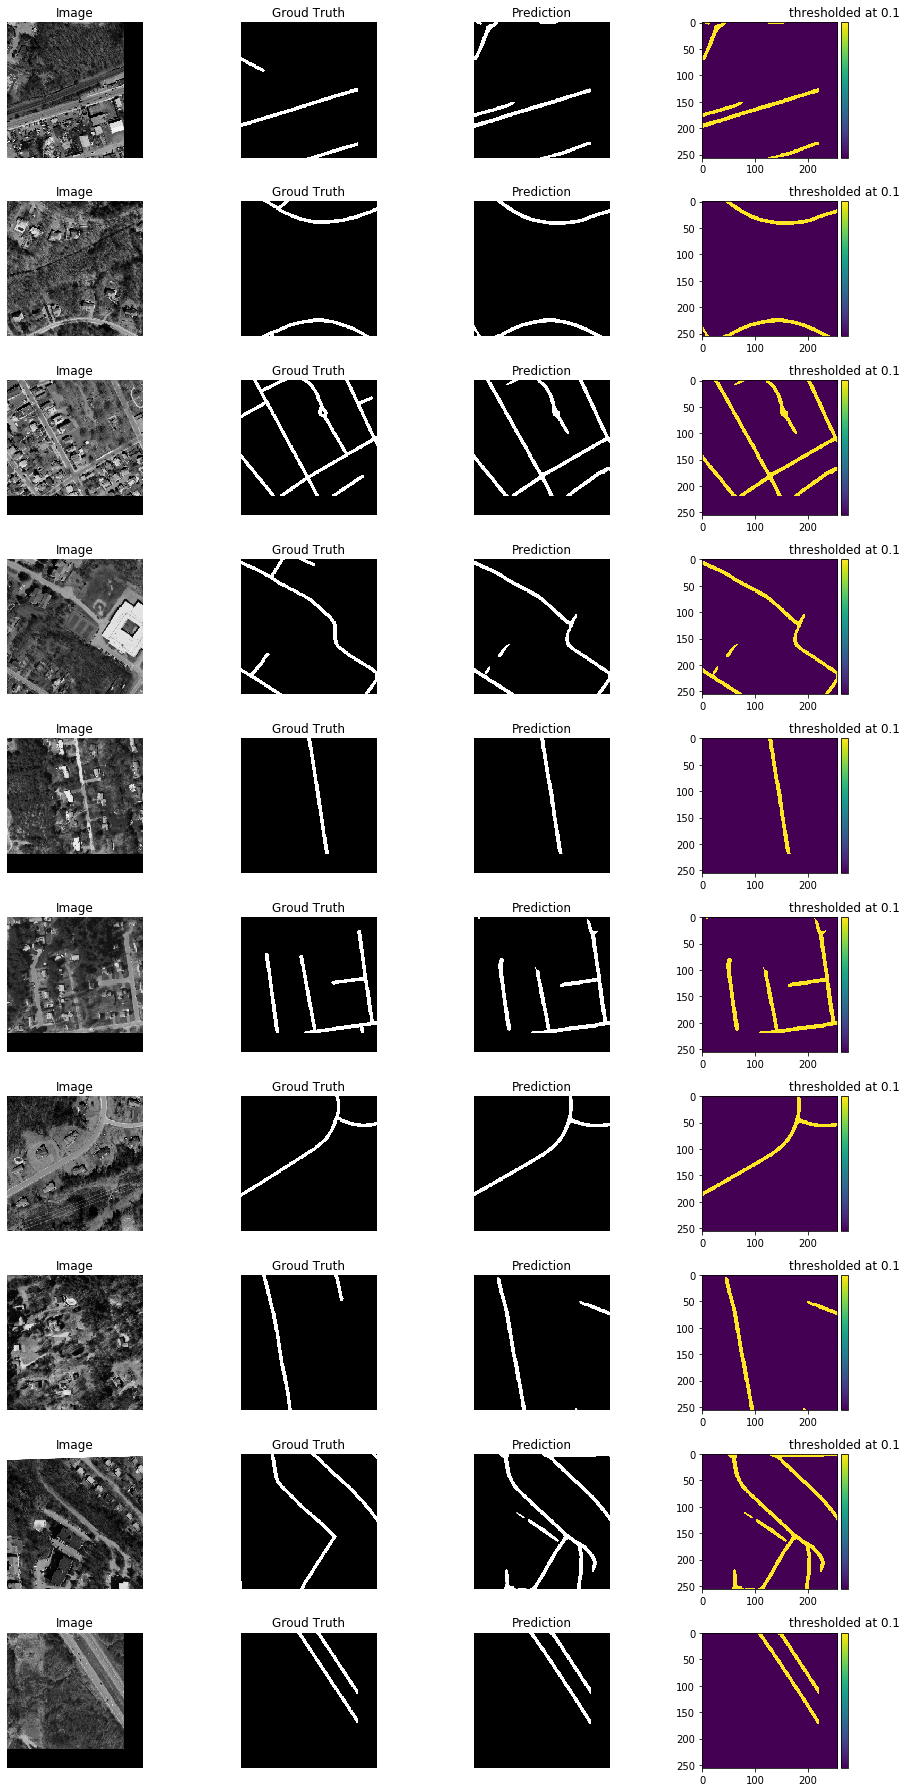

In [28]:
ix = random.randint(0, len(predictions))
num_samples = 10

f = plt.figure(figsize = (15, 25))
for i in range(1, num_samples*4, 4):
  ix = random.randint(0, len(predictions))

  f.add_subplot(num_samples, 4, i)
  imshow(test_images[ix][:,:,0])
  plt.title("Image")
  plt.axis('off')

  f.add_subplot(num_samples, 4, i+1)
  imshow(np.squeeze(test_masks[ix][:,:,0]))
  plt.title("Groud Truth")
  plt.axis('off')

  f.add_subplot(num_samples, 4, i+2)
  imshow(np.squeeze(predictions[ix][:,:,0]))
  plt.title("Prediction")
  plt.axis('off')

  f.add_subplot(num_samples, 4, i+3)
  imshow(np.squeeze(predicton_threshold[ix][:,:,0]))
  plt.title("thresholded at {}".format(thresh_val))
  plt.axis('off')

plt.show()
